In [2]:
import json

In [3]:
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import (precision_recall_fscore_support,
                             roc_auc_score,
                             precision_recall_curve,
                             average_precision_score,
                             roc_curve)
from sklearn.externals import joblib
from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier
np.random.seed(369)
from scipy.interpolate import BSpline, splrep, make_interp_spline

In [5]:
from frag_tools import (DropColumns,
                        AddressLatLong,
                        CurrentMakeDummies,
                        Binarize,
                        ChangeTypes,
                        custom_zip_cleaning)
from various_tools import (roc,
                           plot_roc,
                           cross_val_metrics,
                           make_metric_df)

In [6]:
df = pd.read_csv('/mnt/c/Users/kurtrm/Downloads/Predictive_Maintenance_Transformer_Overload_PA.csv', sep=';')

In [7]:
pipe = make_pipeline(CurrentMakeDummies(['Manufacturer',
                                         'Repairs',
                                         'Overloads',
                                         'AssetType']),
                     ChangeTypes(['Age', 'AssetZip'],
                                 [lambda x: float(x.replace(',', '.')),
                                  custom_zip_cleaning]),
                     Binarize(['VegMgmt',
                               'PMLate',
                               'WaterExposure',
                               'MultipleConnects',
                               'Storm']),
                     AddressLatLong(),
                     DropColumns(['AssetCity',
                                  'AssetId',
                                  'AvgRepairCost',
                                  'AssetState',
                                  'MilesFromOcean',
                                  'AssetLocation',
                                  'locationID',
                                  'Latitude1',
                                  'Longitude1',
                                  'Latitude',
                                  'Longitude',
                                  'Overloads_Below 100%',
                                  'Overloads_100-120%',
                                  'Overloads_120-150%',
                                  'Overloads_Above 150%',
                                  'AssetZip']))
transformed = pipe.fit_transform(df)

In [8]:
transformed.columns

Index(['VegMgmt', 'PMLate', 'WaterExposure', 'MultipleConnects', 'Storm',
       'Age', 'Status', 'Manufacturer_GE', 'Manufacturer_Other',
       'Manufacturer_Schneider Electric', 'Manufacturer_Siemens',
       'Repairs_Original', 'Repairs_Rebuild+1', 'Repairs_Rebuild+2',
       'Repairs_Rebuild+3', 'AssetType_1-Phase Pole Transformer',
       'AssetType_3-Phase Transformer', 'AssetType_DF-series Transformer',
       'AssetType_Padmount Transformer', 'AssetType_Voltage Transformer'],
      dtype='object')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(transformed.drop('Status', axis=1).values, transformed['Status'].values, test_size=.2)

In [10]:
_, gbc_final = joblib.load('refined_models.pkl')

In [11]:
gbc_final.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)

In [12]:
probs = gbc_final.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])

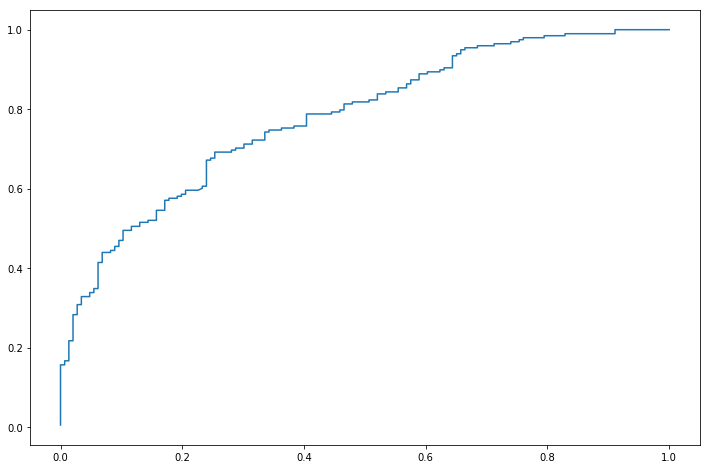

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(fpr, tpr)

In [14]:
roc_auc_score(y_test, probs[:, 1])

0.77980143904801436

In [15]:
line = np.linspace(0, 1, len(thresholds))

In [16]:
listy = []
for fp, tp, thresh, lin in zip(fpr, tpr, thresholds, line):
    listy.append({'fpr': fp, 'tpr': tp, 'thresh': thresh, 'lin': lin})

In [17]:
with open('../src/static/data/roc_data.json', 'w') as f:
    json.dump(listy, f)

In [18]:
joblib.dump(gbc_final, '../src/static/models/final_grad_boost.pkl')

['../src/static/models/final_grad_boost.pkl']

In [19]:
def threshold_prediction(model, X, threshold=0.5):
    """
    Return predictions based on threshold.
    """
    return np.where(model.predict_proba(X)[:, 1] > threshold,
                    model.classes_[1],
                    model.classes_[0])

def confusion_matrix(model, X_test, y_test, threshold=0.5):
    cf = pd.crosstab(y_test, threshold_prediction(model, X_test, threshold))
    cf.index.name = 'actual'
    cf.columns.name = 'predicted'
    return cf.values

In [20]:
cf = confusion_matrix(gbc_final, X_test, y_test, .5)
costs = np.array([[-5, -20], [5, 10]])

In [21]:
def calculate_payout(cb_matrix, model, X, y, threshold):
    return (confusion_matrix(model, X, y, threshold) * cb_matrix).sum()

Text(0.5,0,'thresholds')

Text(0,0.5,'losses')

Text(0.5,1,'Profit Curve')

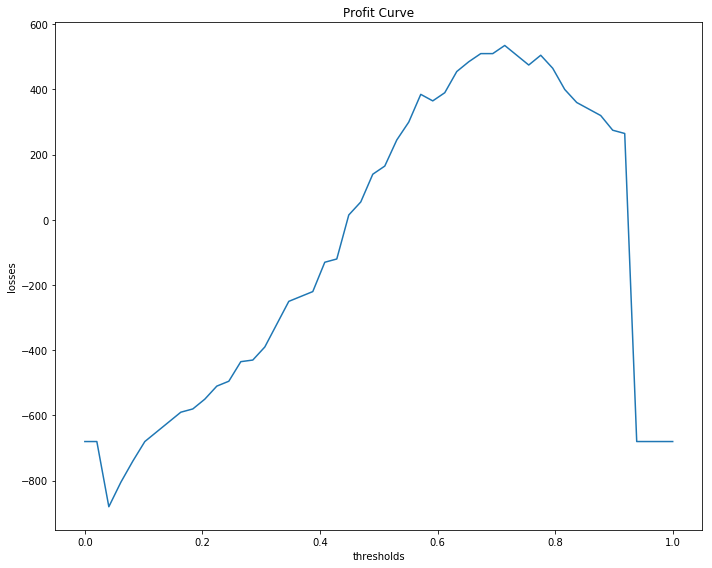

In [27]:
gen_thresholds = np.linspace(0, 1, 50)

fig, ax = plt.subplots(figsize=(10, 8))

profits = []
for thr in gen_thresholds:
    profits.append(calculate_payout(costs, gbc_final, X_test, y_test, thr))
ax.plot(gen_thresholds, np.array(profits))
ax.set_xlabel('thresholds')
ax.set_ylabel('losses')
ax.set_title('Profit Curve')
fig.tight_layout()

In [23]:
splrep(gen_thresholds, np.array(profits))

(array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.03755102,
         0.05632653,  0.07510204,  0.09387755,  0.11265306,  0.13142857,
         0.15020408,  0.16897959,  0.1877551 ,  0.20653061,  0.22530612,
         0.24408163,  0.26285714,  0.28163265,  0.30040816,  0.31918367,
         0.33795918,  0.35673469,  0.3755102 ,  0.39428571,  0.41306122,
         0.43183673,  0.45061224,  0.46938776,  0.48816327,  0.50693878,
         0.52571429,  0.5444898 ,  0.56326531,  0.58204082,  0.60081633,
         0.61959184,  0.63836735,  0.65714286,  0.67591837,  0.69469388,
         0.71346939,  0.7322449 ,  0.75102041,  0.76979592,  0.78857143,
         0.80734694,  0.82612245,  0.84489796,  0.86367347,  0.88244898,
         0.92      ,  0.92      ,  0.92      ,  0.92      ]),
 array([ -680.        ,  -414.53754708, -1095.92490584,  -765.2793079 ,
         -755.61926203,  -712.24364397,  -655.40616207,  -656.13170774,
         -620.06700696,  -583.60026441,  -585.53193538,  -554.27

In [24]:
splines = BSpline(*splrep(gen_thresholds, np.array(profits)))

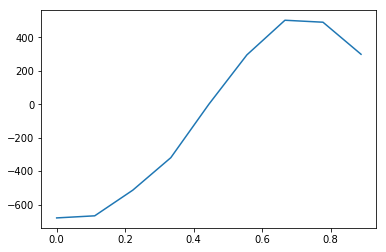

In [25]:
plt.plot(np.linspace(0, 1, 10), splines(np.linspace(0, 1, 10), extrapolate=False))

In [26]:
roc_splines = BSpline(*splrep(fpr_new, tpr_new))
plt.plot(np.linspace(0, 1, 10), roc_splines(np.linspace(0, 1,10), extrapolate=False))

NameError: name 'fpr_new' is not defined

In [ ]:
roc_splines.tck

In [ ]:
fpr_new, fpr_ind = np.unique(fpr, return_index=True)

In [ ]:
tpr_new = tpr[fpr_ind]

In [ ]:
interp = make_interp_spline(fpr_new, tpr_new)

In [ ]:
plt.plot(np.linspace(0, 1, 25), interp(np.linspace(0, 1, 25)))

In [ ]:

def sum_payout(cost_matrix, confusion_matrix):
    """
    Calculate the profit from cost and confusion matrices.
    """
    return (confusion_matrix * cost_matrix).sum()

In [ ]:
def generate_profit_curve(cost_matrix,
                          model,
                          X_test, y_test, n_thresholds=100):
    """
    Generate the profit curve with a given cost matrix.
    """
    thresholds = np.linspace(0, 1, n_thresholds)
    totals = []
    for threshold in thresholds:
        iter_conf_matrix = confusion_matrix(model, X_test, y_test, threshold)
        totals.append(sum_payout(cost_matrix, iter_conf_matrix))

    return thresholds, np.array(totals)

In [ ]:
def diff_generate_profit_curve(cost_matrix,
                               model,
                               X_test, y_test, n_thresholds=100):
    """
    Generate the profit curve with a given cost matrix.
    """
    thresholds = np.linspace(0, 1, n_thresholds)
    totals = np.empty(n_thresholds)
    for i, threshold in enumerate(thresholds):
        iter_conf_matrix = confusion_matrix(model, X_test, y_test, threshold)
        totals[i] = sum_payout(cost_matrix, iter_conf_matrix)

    return thresholds, totals

In [ ]:
%%timeit
generate_profit_curve(costs, gbc_final, X_test, y_test)

In [ ]:
%%timeit
diff_generate_profit_curve(costs, gbc_final, X_test, y_test)

In [ ]:
[[-5, -20],
 [-5,  10]]

In [ ]:
plt.plot(*generate_profit_curve(np.array([[-5, -20], [-5,  10]]),
                      gbc_final, X_test, y_test))

- hourly revenue generation
- hourly maintenance
- hourly repair

In [ ]:
pd.DataFrame(X_test)

In [ ]:
np.concatenate(X_test, y_test.reshape(-1, 1))

In [ ]:
dfed = pd.DataFrame(np.hstack((X_test, y_test.reshape(-1, 1))))

In [ ]:
dfed.head()

In [ ]:
for column in dfed:
    if column != 5:
        dfed.loc[:, column] = dfed.loc[:, column].astype(int)

In [ ]:
dfed

In [ ]:
dfed.loc[0].dtype

In [ ]:
dfed.to_csv('../src/static/data/test_set.csv', header=False, sep=';', index=False)

In [ ]:
dfed.shape

In [ ]:
dfed.values[:, :-1].shape

In [ ]:
X_test.shape

In [ ]:
gbc_final.n_features

In [ ]:
pd.read_csv('../src/static/data/test_set.csv', header=None, sep=';')

In [ ]:
bool("0")

In [ ]:
2 + 2

In [ ]:
pd.read_json('../src/static/data/roc_data.json').to_csv('../src/static/data/roc_data.csv', index=False)

In [ ]:
pd.read_json('../src/static/data/lat_long.json').to_csv('../src/static/data/lat_long.csv', index=False)

In [ ]:
pd.read_json('../src/static/data/thresh_losses.json').to_csv('../src/static/data/thresh_losses.csv', index=False)

In [28]:
arr = np.array([1, 2, 3, 4, 5, 6, 7, 8])

In [29]:
arr.

AttributeError: 'numpy.ndarray' object has no attribute 'trim'